In [2]:
import geoopt
import torch
import numpy as np
import random
import logging
import json

import sys
sys.path.insert(0, "../src")
from models.hyperbolic import ManifoldSkipGram

In [3]:
idx2song = json.load(open("../models/sphere/idx2song.json"))
freqs = json.load(open("../models/sphere/frequencies.json"))
idx2song = {int(k):v for k,v in idx2song.items()}
song2idx = {v:k for k,v in idx2song.items()}

In [4]:
NUM_EMBEDDING = len(idx2song)
print(NUM_EMBEDDING)
EMBEDDING_DIM = 16

manifold = geoopt.manifolds.Sphere()
model = ManifoldSkipGram(manifold, NUM_EMBEDDING, EMBEDDING_DIM, similarity="distance")
model.load_state_dict(torch.load("../models/sphere/model.pt"))
weights = model.encoder.w.detach().numpy()

159957


In [5]:
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.pca import TangentPCA
from geomstats.geometry.hyperboloid import Hyperboloid
from geomstats.geometry.hypersphere import Hypersphere
import geomstats

INFO: Using numpy backend


In [6]:
#manifold = Hyperboloid(dim=weights.shape[-1]-1)
manifold = Hypersphere(dim=weights.shape[-1]-1)

In [7]:
geomstats.backend.all(manifold.belongs(weights))

True

In [8]:
mean = FrechetMean(metric=manifold.metric)
mean.fit(weights)
print(mean.estimate_)

[ 0.18275982 -0.23925047  0.35894354  0.23772572 -0.11869057 -0.20287994
 -0.27535873  0.14154019  0.37530147 -0.03078491 -0.24090223  0.44286392
  0.33652407  0.18929478  0.16572734 -0.01981266]


In [9]:
pole = np.array([1] + [0] * 15)
print(manifold.belongs(pole))
print(pole)

True
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [10]:
distances = manifold.metric.dist(mean.estimate_, weights)
#distances = manifold.metric.dist(pole, weights)

Text(0.5, 0, 'Log frequency of item')

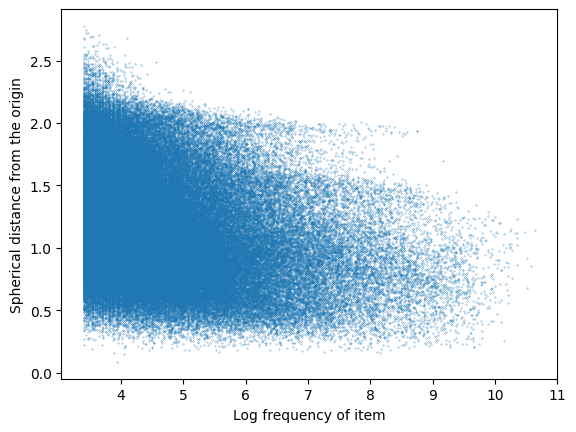

In [11]:
import matplotlib.pyplot as plt
freqs = json.load(open("../models/sphere/frequencies.json"))
freqs = {int(k): v for k,v in freqs.items()}
colors = np.log([freqs[id_] for id_ in song2idx.values()])
plt.scatter(colors, distances, s=0.05)
plt.ylabel("Spherical distance from the origin")
plt.xlabel("Log frequency of item")

In [12]:
import os


import sys
sys.path.insert(0, "../src/")
from models.transformer.loader import PlaylistDataset


# utils to create this file list

def get_file_list(base):
    return [os.path.join(base, f) for f in os.listdir(base) if ".json" in f]

#files = get_file_list("../data/processed/")[:2]
files = ["../data/processed/chunk_18.json", "../data/processed/chunk_19.json"]
dataset = PlaylistDataset(files, 50_000)
len(files), files

(2, ['../data/processed/chunk_18.json', '../data/processed/chunk_19.json'])

# Qrels

In [13]:
from tqdm import tqdm

MIN_LENGTH = 10
data = {}
i = 0

for playlist in tqdm(dataset):
    split = min(30, len(playlist) // 2)
    part1, part2 = playlist[:split], set(playlist[split:])
    if len(part2) < MIN_LENGTH:
        continue
    data[i] = {
        "part2": part2,
        "part1": part1
    }
    i += 1
len(data)

100%|████████████████████████████████| 100000/100000 [00:02<00:00, 43994.15it/s]


84792

In [ ]:
qrels = {k: {s: 1 for s in v["part2"]} for k,v in data.items()}

In [ ]:
with open("../data/qrels.json", "w") as f:
    json.dump(qrels, f)

# Runs

In [305]:
from sklearn.neighbors import NearestNeighbors
from collections import Counter


class ManifoldDistanceNearestNeighbors:
    
    def __init__(self, manifold, k):
        self.k = k
        self.manifold = manifold
        
    def fit(self, x):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x)
        self.x = x
        self.x0 = torch.zeros(x.shape[1]).to(x.device)
        
    @torch.no_grad()
    def _distances(self, x):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x)
        if len(x.shape) > 1:
            return self.manifold.dist2(x[:,None,:], self.x)
        return self.manifold.dist2(self.x, x)
    
    def kneighbors(self, x, return_distance=True, include_self=False):
        distances = self._distances(x)
        order = np.argsort(distances, axis=-1)
        offset, k = 0 if include_self else 1, self.k if include_self else self.k+1
        if return_distance:
            o = order[:, offset:k]
            d = torch.stack([distances[i, o[i]] for i in range(len(o))], dim=0)
            return d.cpu().numpy(), o.cpu().numpy()
        return order[:, offset:k].cpu().numpy()
    
    
class KNNSkipSelfWrapper:
    
    def __init__(self, knn):
        self.knn = knn
        
    def kneighbors(self, x, *args):
        d, n = self.knn.kneighbors(x, return_distances=True)
        d = d[:, 1:]
        n = n[:, 1:]
        return d, n

EPS = 1e-4
class Recommender:
    
    def __init__(self, song2ids, knn, vecs, fallback=None):
        self.song2ids = song2ids
        self.ids2song = {v:k for k,v in song2ids.items()}
        self.known_songs = set(song2ids.keys())
        self._vecs = vecs
        self.knn = knn
        self.knn.fit(vecs)
        self.fallback=fallback
        
    def recommend(self, songs, k=500):
        assert isinstance(songs, list), "Must provide list!"
        songs = list(filter(lambda song: song in self.known_songs, songs))
        if len(songs) == 0:
            print("Using fallback")
            return self.fallback.recommend(songs)
        ids = [self.song2ids[song] for song in songs]
        vecs = self._vecs[ids]
        distances, nns = self.knn.kneighbors(vecs, return_distance=True)
        nns = nns.reshape(-1)
        distances = distances.reshape(-1)
        distances = {neigh: dist for neigh, dist in zip(nns, distances)}
        c = Counter(nns)
        rec = [idx for idx,count in c.most_common(k)]
        # convert distance to similarity score
        rec_scores = [1 / (EPS + distances[r]) for r in rec]
        # translate song id to uri
        rec = [self.ids2song[idx] for idx in rec]
        return rec, rec_scores
    
    
class MinDistanceRecommender:
    
    def __init__(self, song2ids, knn, vecs, fallback=None):
        self.song2ids = song2ids
        self.ids2song = {v:k for k,v in song2ids.items()}
        self.known_songs = set(song2ids.keys())
        self._vecs = vecs
        self.knn = knn
        self.knn.fit(vecs)
        self.fallback=fallback
        
    def recommend(self, songs, k=500):
        assert isinstance(songs, list), "Must provide list!"
        songs = list(filter(lambda song: song in self.known_songs, songs))
        if len(songs) == 0:
            print("Using fallback")
            return self.fallback.recommend(songs)
        ids = [self.song2ids[song] for song in songs]
        vecs = self._vecs[ids]
        distances, nns = self.knn.kneighbors(vecs, return_distance=True)
        nns = nns.reshape(-1).tolist()
        distances = distances.reshape(-1).tolist()
        d = {}
        for n, dist in zip(nns, distances):
            if n not in d:
                d[n] = dist
            else:
                d[n] = min(dist, d[n])
        d = sorted(d.items(), key=lambda x: x[1])
        rec, rec_scores = list(zip(*d))
        
        rec = [self.ids2song[idx] for idx in rec]
        return rec[:k], rec_scores[:k]
    
    
class PopularRecommender:
    
    def __init__(self, freqs, song2ids):
        c = Counter(freqs)
        ids2song = {v:k for k,v in song2ids.items()}
        self.rec = list(zip(*c.most_common(len(c))))
        self.rec[0] = [ids2song[i] for i in self.rec[0] if i in ids2song]
        
    def recommend(self, songs, k=500):
        return self.rec[0][:k], self.rec[1][:k]
    
    
from scipy.sparse import csr_matrix
    
class SparseKNNRecommender:
    
    def __init__(self, R, song2idx, idx2song, fallback, max_playlists=500):
        self.R = R
        self.song2idx = song2idx
        self.idx2song = idx2song
        self.known_songs = set(self.song2idx.keys())
        self.fallback = fallback
        self.max_playlists = max_playlists
        
    def _convert_playlist(self, indices):
        z = np.ones_like(indices, dtype=np.int64)
        return csr_matrix((z, (indices, z*0)), shape=(self.R.shape[1], 1))
        
    def recommend(self, songs, k=500):
        assert isinstance(songs, list), "Must provide list!"
        songs = list(filter(lambda song: song in self.known_songs, songs))
        if len(songs) == 0:
            print("Using fallback")
            return self.fallback.recommend(songs)
        indices = [self.song2idx[song] for song in songs]
        songs = self._convert_playlist(indices)
        scores = self.R @ songs
        score_idx = scores.nonzero()[0]
        # select top n playlists
        if len(score_idx) > self.max_playlists:
            score_value = scores[score_idx, 0].todense()
            score_value = np.array(score_value).flatten()
            order = np.argsort(score_value)[::-1][:self.max_playlists]
            score_idx = score_idx[order]
        # collect songs
        # TODO: sort only nonzero elements
        z = self.R[score_idx].sum(axis=0)
        nz = z.nonzero()[1]
        values = np.array(z[0, nz]).flatten()
        order = np.argsort(values)[-k+len(indices):][::-1]
        rec = [idx for idx in nz[order] if idx not in indices][:k]
        return [self.idx2song[idx] for idx in rec], [1] * len(rec)
    
    
import random
class RandomRecommender:
    
    def __init__(self, songs):
        self.songs = songs
        
    def recommend(self, songs, k=500):
        z = random.choices(self.songs, k=k)
        return z, [1] * len(z)

In [239]:
import os
from scipy.sparse import load_npz

def load_sparse(path):
    with open(os.path.join(path, "idx2song.json")) as f:
        idx2song = json.load(f)
        idx2song = {int(k):v for k,v in idx2song.items()}
    song2idx = {v:k for k,v in idx2song.items()}
    R = load_npz(os.path.join(path, "r.npz"))
    return R, song2idx, idx2song

model = load_sparse("../models/sparse")

In [233]:
r_pop = PopularRecommender(freqs, song2idx)
r_random = RandomRecommender(list(song2idx.keys()))

In [306]:
from sklearn.neighbors import NearestNeighbors
#nn = ManifoldDistanceNearestNeighbors(model.encoder._manifold, 100)
#nn = NearestNeighbors(n_neighbors=100+1, metric="cosine")
#r = Recommender(song2idx, nn, weights, fallback=r_pop)

r = SparseKNNRecommender(*model, r_pop, 100)

In [ ]:
run = {}
for i, parts in tqdm(data.items()):
    part1, part2 = parts["part1"], parts["part2"]
    recs, scores = r.recommend(part1, k=100)
    entry = {song: score for song, score in zip(recs, scores)}
    run[i] = entry

  0%|                                       | 3/84792 [00:01<8:59:52,  2.62it/s]

In [255]:
with open("../data/sparse.json", "w") as f:
    json.dump(run, f)

# Eval

In [256]:
from ranx import Qrels, Run
from ranx import evaluate
import json

In [257]:
run_json = json.load(open("../data/sparse.json"))
qrels_json = json.load(open("../data/qrels.json"))
qrels_json = {k:v for k,v in qrels_json.items() if k in run_json}
qrels = Qrels(qrels_json)
run = Run(run_json)

In [258]:
evaluate(qrels, run, ["mrr", "hit_rate", "recall", "precision"])

{'mrr': 0.0, 'hit_rate': 0.0, 'recall': 0.0, 'precision': 0.0}

In [3]:
evaluate(qrels, run, ["mrr", "hit_rate", "recall", "precision"])

{'mrr': 0.13145022008717888,
 'hit_rate': 0.8221294461741674,
 'recall': 0.13159084123043213,
 'precision': 0.05556278894235305}

In [30]:
keep = set(str(x) for x in range(1000))
run_lorentz = json.load(open("../data/lorentzv2.json"))
print(len(run_lorentz))
run_lorentz = {k:v for k,v in run_lorentz.items() if k in keep}
run_euclidean = json.load(open("../data/euclidean.json"))
run_euclidean = {k:v for k,v in run_euclidean.items() if k in keep}
qrels_json = json.load(open("../data/qrels.json"))
qrels_json = {k:v for k,v in qrels_json.items() if k in keep}
qrels = Qrels(qrels_json)
run_lorentz = Run(run_lorentz)
run_euclidean = Run(run_euclidean)

1073


In [31]:
metrics = ["mrr", "hit_rate", "recall", "f1", "ndcg", "map"]
ks = list(range(5, 105, 5))

reuslts_lorentz = {metric: [] for metric in metrics}
results_euclidean = {metric: [] for metric in metrics}
for k in ks:
    print("k =", k)
    ms = [f"{m}@{k}" for m in metrics]
    lor, euc = evaluate(qrels, run_lorentz, ms), evaluate(qrels, run_euclidean, ms)
    for m in ms:
        reuslts_lorentz[m.split("@")[0]].append(lor[m])
        results_euclidean[m.split("@")[0]].append(euc[m])

k = 5
k = 10
k = 15
k = 20
k = 25
k = 30
k = 35
k = 40
k = 45
k = 50
k = 55
k = 60
k = 65
k = 70
k = 75
k = 80
k = 85
k = 90
k = 95
k = 100


In [32]:
metrics

['mrr', 'hit_rate', 'recall', 'f1', 'ndcg', 'map']

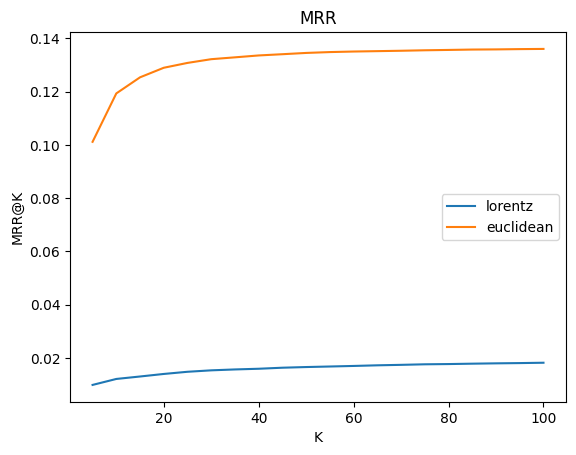

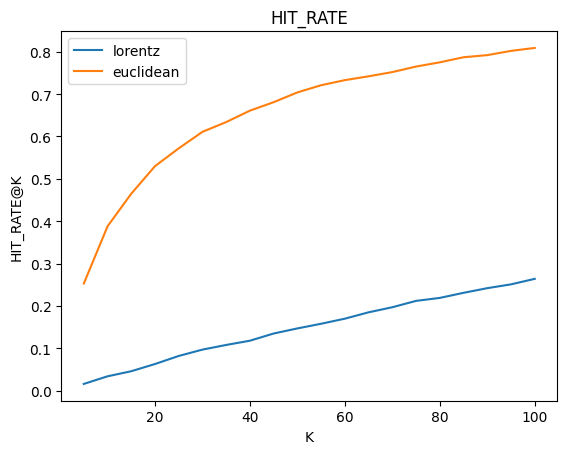

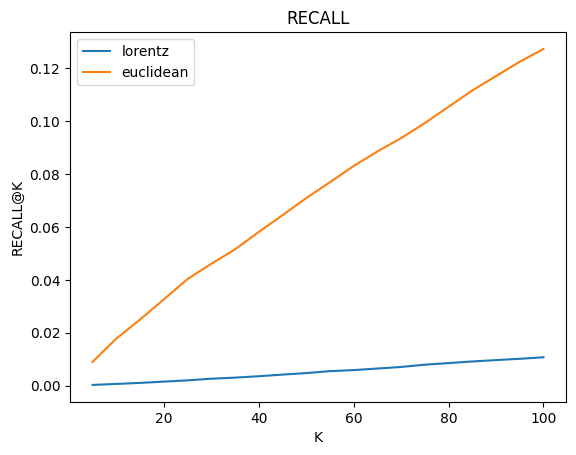

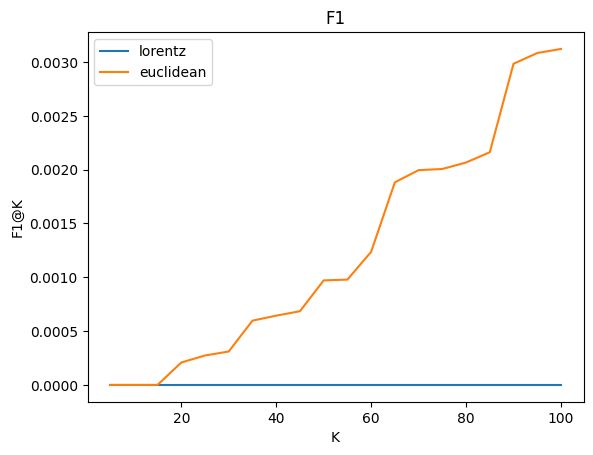

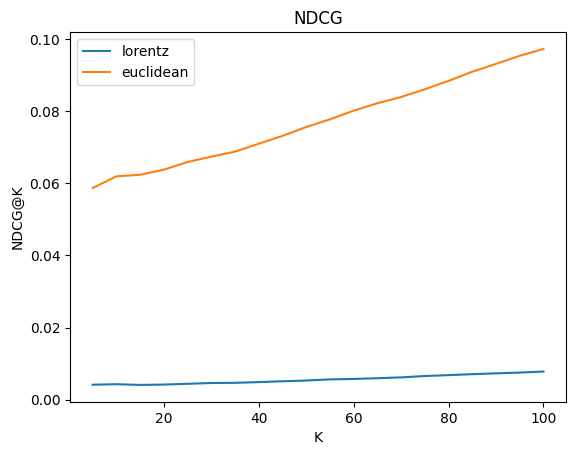

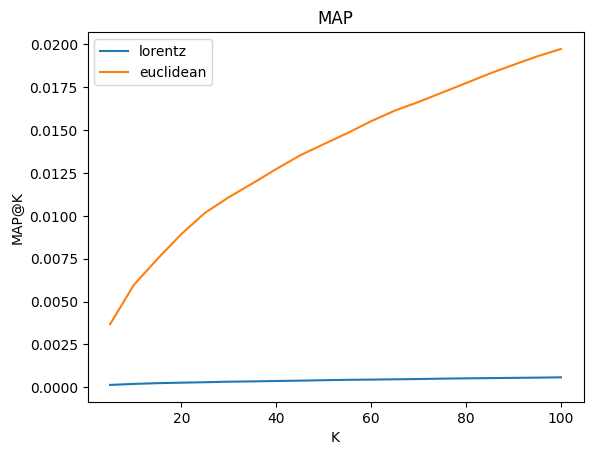

In [34]:
import matplotlib.pyplot as plt
for m in metrics:
    plt.plot(ks, reuslts_lorentz[m])
    plt.plot(ks, results_euclidean[m])
    plt.legend(["lorentz", "euclidean"])
    plt.title(m.upper())
    plt.ylabel(f"{m}@K".upper())
    plt.xlabel("K")
    plt.show()

# Mérések

In [1]:
import json
from functools import reduce
from tqdm import tqdm

In [2]:
with open("../models/lorentz/frequencies.json", "r") as f:
    freqs = json.load(f)
    
with open("../models/lorentz/idx2song.json", "r") as f:
    idx2song = json.load(f)
    
freqs = {idx2song[s]: v for s,v in freqs.items()}

In [3]:
with open("../data/qrels.json", "r") as f:
    qrels = json.load(f)

In [4]:
songs = set()
for pl in qrels.values():
    songs.update(pl.keys())
len(songs)

566158

In [5]:
# dalonként megnézni, hogy mekkora a precision és mekkora a recall
K = 100

with open("../data/lorentz.json", "r") as f:
    data = json.load(f)

def fltr(rec):
    return rec[1]

data = {str(i): sorted(data[str(i)].items(), key=fltr)[-K:][::-1] for i in data.keys()}

In [6]:
ss = {s: {"tp": 0, "fp": 0, "fn": 0, "recommendation_frequency": 0} for s in songs}
unknown_songs = set()
for i in tqdm(data.keys()):
    rec = list(zip(*data[i]))[0]
    qrel = list(qrels[i].keys())
    for song in qrel:
        if song in rec:
            ss[song]["tp"] += 1
        else:
            ss[song]["fn"] += 1
    for song in rec:
        if song not in qrel:
            try:
                ss[song]["fp"] += 1
            except KeyError:
                unknown_songs.add(song)

100%|███████████████████████████████████| 84792/84792 [00:15<00:00, 5644.24it/s]


In [7]:
len(unknown_songs)

1876

In [8]:
def recall(stats):
    return stats["tp"] / (stats["tp"] + stats["fn"])

z = 0
for song in tqdm(ss.keys()):
    ss[song]["recall"] = recall(ss[song])
    try:
        ss[song]["frequency"] = freqs[song]
    except KeyError:
        ss[song]["frequency"] = 0
        

100%|███████████████████████████████| 566158/566158 [00:00<00:00, 911762.79it/s]


0

In [19]:
for song in tqdm(ss.keys()):
    ss[song]["evidence"] = sum(ss[song][k] for k in ["tp", "fp", "fn"])

100%|██████████████████████████████| 566158/566158 [00:00<00:00, 1386456.07it/s]


In [9]:
song_stats = {s: {"n_rec": 0, "freq": f} for s, f in freqs.items()}
for i in tqdm(data.keys()):
    rec = list(zip(*data[i]))[0]
    for song in rec:
        song_stats[song]["n_rec"] += 1

100%|██████████████████████████████████| 84792/84792 [00:04<00:00, 19501.45it/s]


Text(0, 0.5, 'recommendation frequency')

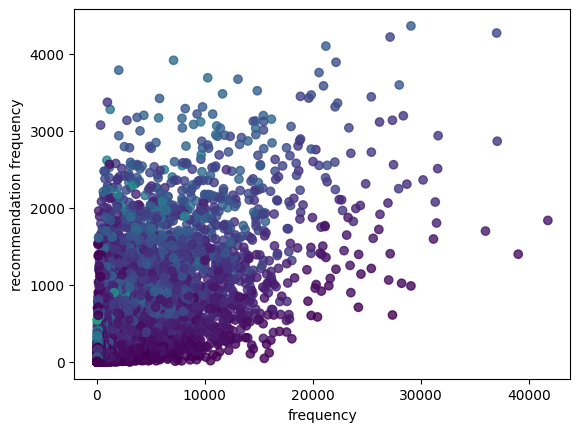

In [10]:
import matplotlib.pyplot as plt

r_frequencies = [s["n_rec"] for s in song_stats.values()]
frequencies = [s["freq"] for s in song_stats.values()]
colors = [ss[s]["recall"] if s in ss else 0 for s in song_stats.keys()]

plt.scatter(frequencies, r_frequencies, alpha=.8, c=colors)
plt.colorbar
plt.xlabel("frequency")
plt.ylabel("recommendation frequency")

Text(0, 0.5, 'times recommended')

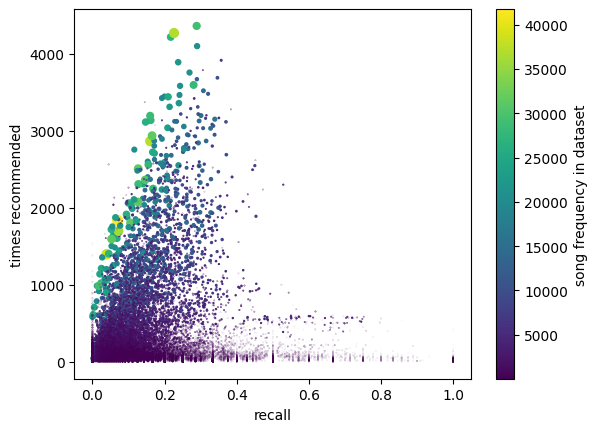

In [11]:
import numpy as np
z = np.array(frequencies)
plt.scatter(colors, r_frequencies, s=50 * (z / max(z))**2, c=frequencies)
cbar = plt.colorbar()
cbar.set_label("song frequency in dataset")
plt.colorbar
plt.xlabel("recall")
plt.ylabel("times recommended")

Text(0, 0.5, 'recall')

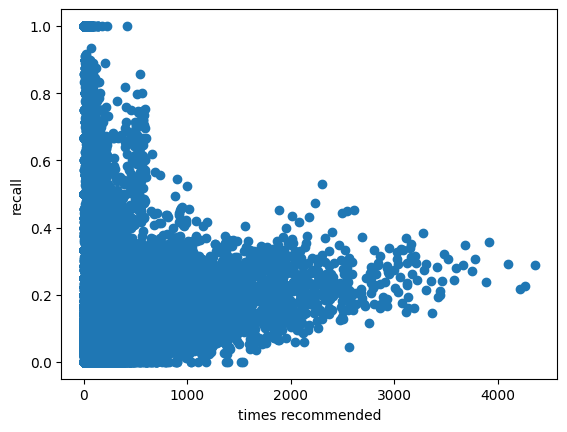

In [25]:
plt.scatter(r_frequencies, colors)
plt.xlabel("times recommended")
plt.ylabel("recall")

Text(0, 0.5, 'recall')

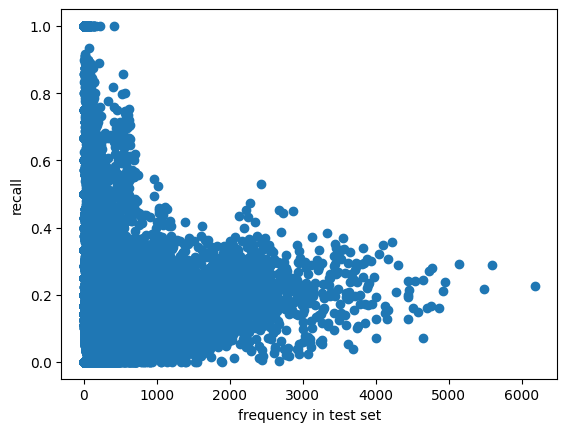

In [26]:
plt.scatter([s["evidence"] for s in ss.values()], [s["recall"] for s in ss.values()])
plt.xlabel("frequency in test set")
plt.ylabel("recall")

In [29]:
common_songs = set(ss.keys()) & set(freqs.keys())

Text(0, 0.5, 'frequency in train set')

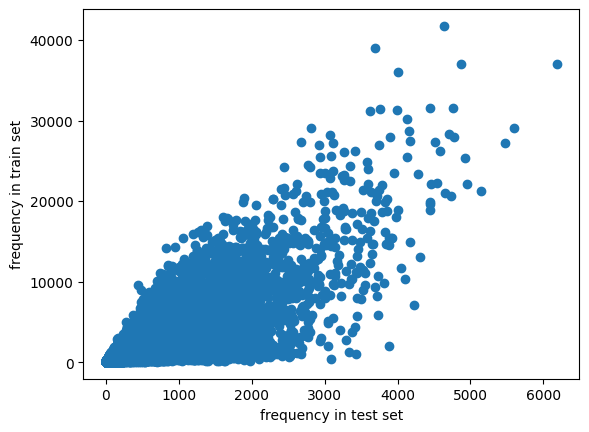

In [31]:
plt.scatter([ss[s]["evidence"] for s in common_songs], [freqs[s] for s in common_songs])
plt.xlabel("frequency in test set")
plt.ylabel("frequency in train set")

Text(0, 0.5, 'recall')

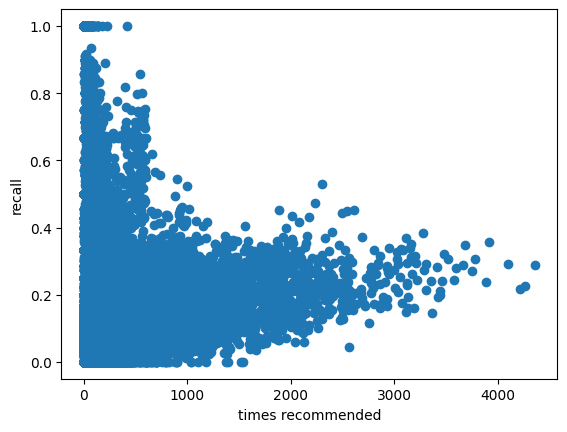

In [34]:
plt.scatter([song_stats[s]["n_rec"] for s in common_songs], [ss[s]["recall"] for s in common_songs])
plt.xlabel("times recommended")
plt.ylabel("recall")